## Import functions

In [1]:
#standard modules
import os
import glob

#import mdanalyis modules and packages
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align, distances

#matplotlib
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

#numpy
import numpy as np

#pandas
import pandas as pd

#nglview
import nglview

#seaborn
import seaborn as sns

#scipy
from scipy.stats import gaussian_kde

In [5]:
### Notes

#Scripts included here:

#Done:
#RMSD 
#RMSF 
#PCA 
#Correlated motions 

#In progress
#Hydrogen bond analyis (for electrostatic interactions as well?)
#Active site distance
#Active site triangle (area)
#Active site pocket size (volume)
#Kmeans clustering on pocket volume (POVME)
#M49 penetration
#Etc.

In [6]:
#define
#calculate
#plot
#save

# define path -done
#load the processed trajectories and topology files (triplicates) -done
#are in the right place (onedrive/amaro_phd/proejcts/md_data/) -done

# define systems (universe): -done
#each system/state will include three universes from which the averages -done
#and errors will be calculated -missing

#apo monomer/dimer - done
#nirm monomer/dimer/asym
#ens monomer/dimer/asym

#to-do
#boc
#nat

# separate into monomer and dimer states -donels -l
# further divide into unbound/bound monomers
# futher divide into unbound/bound dimers
# for dimers look into dimerizing interactions (compare to monomer)
# monomer vs. dimer in the apo state
# look at the interaction document to make variables for different regions
# interdomain dynamics (dimer vs. monomer)

## Define Paths

In [4]:
project_path = '/Users/javingfun/Library/CloudStorage/OneDrive-UCSanDiego/UCSD/PhD/Active/mpro-trajectories'

#apo path
apo_path = os.path.join(project_path,'mpro_apo')
apo_monomer_path = os.path.join(apo_path,'mpro_apo_monomer')
apo_dimer_path = os.path.join(apo_path,'mpro_apo_dimer')

#ens_path
ens_path = os.path.join(project_path,'mpro_ens')
ens_monomer_path = os.path.join(ens_path,'mpro_ens_monomer')
ens_dimer_path = os.path.join(ens_path,'mpro_ens_dimer')
ens_dimer_asym_path = os.path.join(ens_path,'mpro_ens_dimer_asym')

#nirm_path
nirm_path = os.path.join(project_path,'mpro_nirm')
nirm_monomer_path = os.path.join(nirm_path,'mpro_nirm_monomer')
nirm_dimer_path = os.path.join(nirm_path,'mpro_nirm_dimer')
nirm_dimer_asym_path = os.path.join(nirm_path,'mpro_nirm_dimer_asym')

In [5]:
apo_monomer_path

'/Users/javingfun/Library/CloudStorage/OneDrive-UCSanDiego/UCSD/PhD/Active/mpro-trajectories/mpro_apo/mpro_apo_monomer'

## Create universes

In [6]:
def make_universe(path,replica):
    
    #obtain trajectory and topology from file, create a universe
    if replica == 0:
        topology = glob.glob(os.path.join(path,'*.pdb'))
        u = mda.Universe(topology[0])
        
    
    else:
        topology = glob.glob(os.path.join(path,'*.prmtop'))
        trajectory = glob.glob(os.path.join(path, '*{rep}.nc'.format(rep=replica))) 
        u = mda.Universe(topology[0], trajectory[0])
        
    return u

## RMSD

### Get RMSD for each replica

In [7]:
def calc_rmsd_reps(u_traj,u_ref,title,protomer):
    
    #u_traj = trajectory
    #u_ref = reference PDB
    #title = abbreviation for data file
    #protomer = a or b (for dimer do a and b)
    
    #region        column   site
    #    global      3:     global (1-306) 
    #    domain1     4:     domain I (8-101)
    #    domain2     5:     domain II (102-184)
    #    domain3     6:     domain III (201-303)
    
    #    nterm       10:    N-term (1-14)
    #    cterm       11:    C-term (298-306)
    
    #    lid         9:     Lid (40-55)
    #    longstrand  8:     Long Strand (155-168)
    #    idl         7:     IDL (185-200)
    
    #if protomer is b, renumber selections, else proceed with normal numbering
    
    selections_a = ['backbone and (resid 1-306) and name CA',
                    'backbone and (resid 8-101) and name CA',
                    'backbone and (resid 102-184) and name CA',
                    'backbone and (resid 201-303) and name CA',
                    'backbone and (resid 185-200) and name CA',
                    'backbone and (resid 131-146) and name CA',
                    'backbone and (resid 40-55) and name CA',
                    'backbone and (resid 1-14) and name CA',
                    'backbone and (resid 298-306) and name CA']
    
    selections_b = ['backbone and (resid 307-612) and name CA',
                    'backbone and (resid 314-407) and name CA',
                    'backbone and (resid 408-490) and name CA',
                    'backbone and (resid 507-609) and name CA',
                    'backbone and (resid 491-506) and name CA',
                    'backbone and (resid 437-452) and name CA',
                    'backbone and (resid 346-361) and name CA',
                    'backbone and (resid 307-320) and name CA',
                    'backbone and (resid 604-612) and name CA'] 
    
    if protomer == 'a':
        R = mda.analysis.rms.RMSD(u_traj,u_ref,
                                 select="backbone",
                                 groupselections= selections_a)
        R.run(start=0,stop=1000)
        
        with open('{}_rmsd.npy'.format(title),'wb') as f:
            np.save(f,R.rmsd)
        print("Finished") 

    elif protomer == 'b':
        R = mda.analysis.rms.RMSD(u_traj,u_ref,
                                 select="backbone",
                                 groupselections= selections_b)
        R.run(start=0,stop=1000)
        
        with open('{}_rmsd.npy'.format(title),'wb') as f:
            np.save(f,R.rmsd)
        print("Finished")
        
    return(R.rmsd)

### Obtain mean RMSD from replicas

In [8]:
def calc_rmsd_mean(rep1,rep2,rep3,site):
    
    rep_list = [rep1,rep2,rep3]
    mean = []
    
    site_dict = {'protomer':3,'domain1':4,'domain2':5,'domain3':6,
                 'idl':7,'longloop':8, 'lid':9,'nterm':10,'cterm':11}
    
    for rep in rep_list:
        avg = np.average(rep[:,site_dict[site]])
        mean.append(avg)
    return np.average(mean)

### Make single plot for a given RMSD run

In [9]:
def plot_rmsd(rep1,rep2,rep3,site):
    
    mean = calc_rmsd_mean(rep1,rep2,rep3,site)
    
    #plot rmsd
    site_dict = {'protomer':3,'domain1':4,'domain2':5,'domain3':6,
                 'idl':7,'longloop':8, 'lid':9,'nterm':10,'cterm':11}
    
    plt.plot(rep1[:,0],rep1[:,site_dict[site]],color='red')
    plt.plot(rep2[:,0],rep2[:,site_dict[site]],color='orange')
    plt.plot(rep3[:,0],rep3[:,site_dict[site]],color='gold')
    plt.axhline(mean,linestyle='--',color='black')
    #plt.title(site.upper() + ' RMSD')
    #plt.xlabel('Frames (ns)')
    #plt.ylabel('RMSD')
    plt.ylim(0,10)


## RMSD apo

### Create universe for apo monomer and dimer systems (0 for reference PDB)

In [10]:
#apo monomer
am_0 = make_universe(apo_monomer_path,0)
am_1 = make_universe(apo_monomer_path,1)
am_2 = make_universe(apo_monomer_path,2)
am_3 = make_universe(apo_monomer_path,3)

In [11]:
#apo dimer
ad_0 = make_universe(apo_dimer_path,0)
ad_1 = make_universe(apo_dimer_path,1)
ad_2 = make_universe(apo_dimer_path,2)
ad_3 = make_universe(apo_dimer_path,3)

#ens dimer
ed_0 = make_universe(ens_dimer_path,0)
ed_1 = make_universe(ens_dimer_path,1)
ed_2 = make_universe(ens_dimer_path,2)
ed_3 = make_universe(ens_dimer_path,3)

#ens dimer asym
ea_0 = make_universe(ens_dimer_asym_path,0)
ea_1 = make_universe(ens_dimer_asym_path,1)
ea_2 = make_universe(ens_dimer_asym_path,2)
ea_3 = make_universe(ens_dimer_asym_path,3)


#nirm dimer
nd_0 = make_universe(nirm_dimer_path,0)
nd_1 = make_universe(nirm_dimer_path,1)
nd_2 = make_universe(nirm_dimer_path,2)
nd_3 = make_universe(nirm_dimer_path,3)

#nirm dimer asym
na_0 = make_universe(nirm_dimer_asym_path,0)
na_1 = make_universe(nirm_dimer_asym_path,1)
na_2 = make_universe(nirm_dimer_asym_path,2)
na_3 = make_universe(nirm_dimer_asym_path,3)


/Users/javingfun/miniconda3/envs/mdaenv/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


### Calculate and plot global RMSD including the mean (error bar is missing)

In [29]:
#calc_rmsd_reps for 1 2 3 (starting with global rmsd)
am_1_rmsd = calc_rmsd_reps(am_1,am_0,'am_1_a','a')
am_2_rmsd = calc_rmsd_reps(am_2,am_0,'am_2_a','a')
am_3_rmsd = calc_rmsd_reps(am_3,am_0,'am_3_a','a')

ad_1_rmsd_a = calc_rmsd_reps(ad_1,ad_0,'ad_1_a','a')
ad_2_rmsd_a = calc_rmsd_reps(ad_2,ad_0,'ad_2_a','a')
ad_3_rmsd_a = calc_rmsd_reps(ad_3,ad_0,'ad_3_a','a')

ad_1_rmsd_b = calc_rmsd_reps(ad_1,ad_0,'ad_1_b','b')
ad_2_rmsd_b = calc_rmsd_reps(ad_2,ad_0,'ad_2_b','b')
ad_3_rmsd_b = calc_rmsd_reps(ad_3,ad_0,'ad_3_b','b')

#this needs to be fixed ()
am_rmsd_mean = calc_rmsd_mean(am_1_rmsd,am_2_rmsd,am_3_rmsd,'protomer')
ad_rmsd_mean_a = calc_rmsd_mean(ad_1_rmsd_a,ad_2_rmsd_a,ad_3_rmsd_a,'protomer')
ad_rmsd_mean_b = calc_rmsd_mean(ad_1_rmsd_b,ad_2_rmsd_b,ad_3_rmsd_b,'protomer')

/Users/javingfun/miniconda3/envs/mdaenv/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished


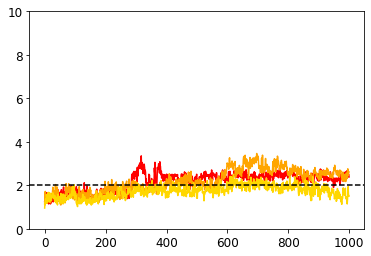

In [30]:
plot_rmsd(ad_1_rmsd_a,ad_2_rmsd_a,ad_3_rmsd_a,'protomer')

In [31]:
am_1_rmsd[:,0]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

Text(0, 0.5, 'Global (1-306)')

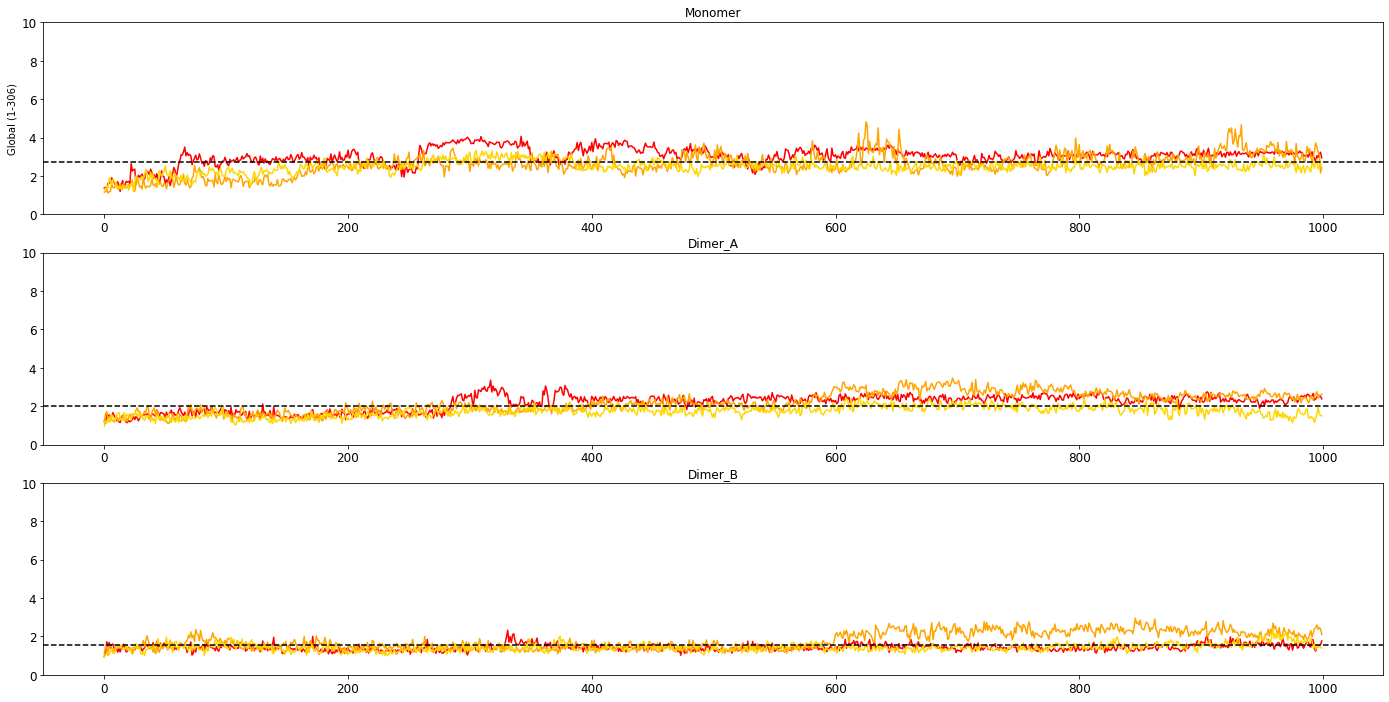

In [32]:
#plot_rmsd in a separate cell
fig, ax = plt.subplots(3,1,figsize=(24,12))

#first column: apo monomer
ax[0].plot(am_1_rmsd[:,0],am_1_rmsd[:,3],color='red')
ax[0].plot(am_2_rmsd[:,0],am_2_rmsd[:,3],color='orange')
ax[0].plot(am_3_rmsd[:,0],am_3_rmsd[:,3],color='gold')
ax[0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[0].set_ylim(0,10)

#second column: apo dimer protomer a
ax[1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,3],color='red')
ax[1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,3],color='orange')
ax[1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,3],color='gold')
ax[1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[1].set_ylim(0,10)

#third column: apo dimer protomer b
ax[2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,3],color='red')
ax[2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,3],color='orange')
ax[2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,3],color='gold')
ax[2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[2].set_ylim(0,10)

ax[0].set_title("Monomer")
ax[1].set_title("Dimer_A")
ax[2].set_title("Dimer_B")

ax[0].set_ylabel("Global (1-306)")

## RMSD apo (by domain)

Text(0, 0.5, 'Domain III (201-303)')

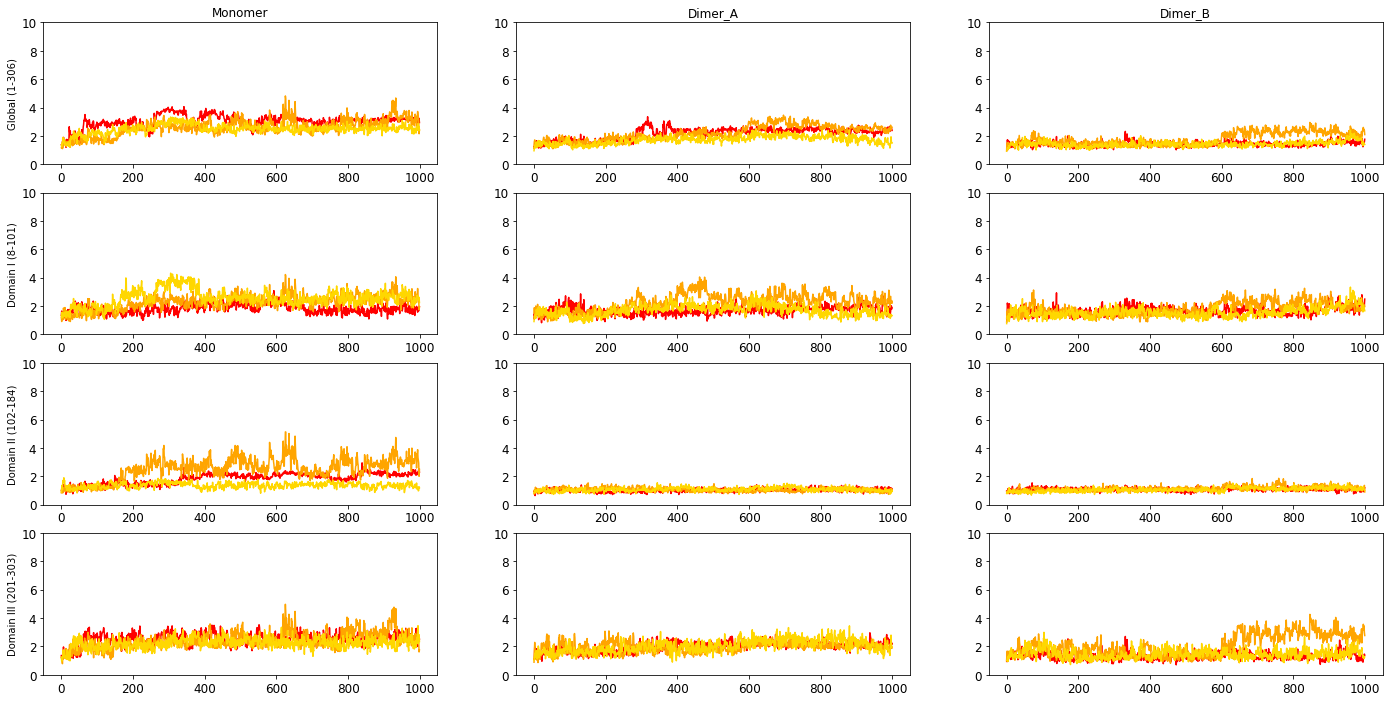

In [33]:
#region        column   site
#    global      3:     global (1-306) 
#    domain1     4:     domain I (8-101)
#    domain2     5:     domain II (102-184)
#    domain3     6:     domain III (201-303)

fig, ax = plt.subplots(4,3,figsize=(24,12))

#first column: apo monomer
ax[0,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,3],color='red')
ax[0,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,3],color='orange')
ax[0,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,3],color='gold')
#ax[0,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[0,0].set_ylim(0,10)

ax[1,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,4],color='red')
ax[1,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,4],color='orange')
ax[1,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,4],color='gold')
#ax[1,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[1,0].set_ylim(0,10)

ax[2,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,5],color='red')
ax[2,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,5],color='orange')
ax[2,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,5],color='gold')
#ax[2,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[2,0].set_ylim(0,10)

ax[3,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,6],color='red')
ax[3,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,6],color='orange')
ax[3,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,6],color='gold')
#ax[3,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[3,0].set_ylim(0,10)

#second column: apo dimer protomer a
ax[0,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,3],color='red')
ax[0,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,3],color='orange')
ax[0,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,3],color='gold')
#ax[0,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[0,1].set_ylim(0,10)

ax[1,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,4],color='red')
ax[1,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,4],color='orange')
ax[1,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,4],color='gold')
#ax[1,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[1,1].set_ylim(0,10)

ax[2,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,5],color='red')
ax[2,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,5],color='orange')
ax[2,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,5],color='gold')
#ax[2,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[2,1].set_ylim(0,10)

ax[3,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,6],color='red')
ax[3,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,6],color='orange')
ax[3,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,6],color='gold')
#ax[3,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[3,1].set_ylim(0,10)

#third column: apo dimer protomer b
ax[0,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,3],color='red')
ax[0,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,3],color='orange')
ax[0,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,3],color='gold')
#ax[0,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[0,2].set_ylim(0,10)

ax[1,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,4],color='red')
ax[1,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,4],color='orange')
ax[1,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,4],color='gold')
#ax[1,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[1,2].set_ylim(0,10)

ax[2,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,5],color='red')
ax[2,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,5],color='orange')
ax[2,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,5],color='gold')
#ax[2,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[2,2].set_ylim(0,10)

ax[3,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,6],color='red')
ax[3,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,6],color='orange')
ax[3,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,6],color='gold')
#ax[3,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[3,2].set_ylim(0,10)

ax[0,0].set_title("Monomer")
ax[0,1].set_title("Dimer_A")
ax[0,2].set_title("Dimer_B")

ax[0,0].set_ylabel("Global (1-306)")
ax[1,0].set_ylabel("Domain I (8-101)")
ax[2,0].set_ylabel("Domain II (102-184)")
ax[3,0].set_ylabel("Domain III (201-303)")

#variables for function 
##ax[num].plot(name[:,0],name[:,site_dict[site]])

## RMSD apo (by termini)

Text(0, 0.5, 'C-term (298-306)')

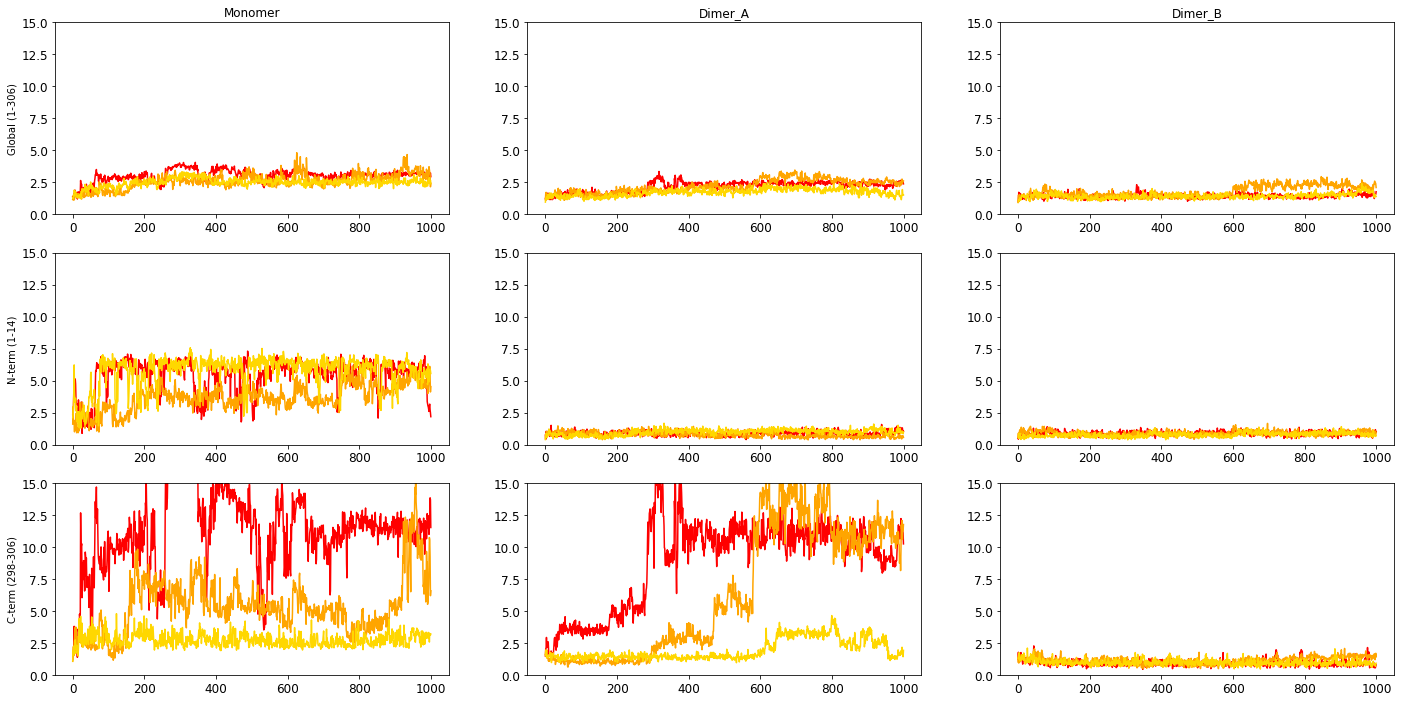

In [34]:
#    global      3:     global (1-306) 
#    nterm       10:    N-term (1-14)
#    cterm       11:    C-term (298-306)

fig, ax = plt.subplots(3,3,figsize=(24,12))

#apo monomer
ax[0,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,3],color='red')
ax[0,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,3],color='orange')
ax[0,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,3],color='gold')
#ax[0,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[0,0].set_ylim(0,15)

ax[1,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,10],color='red')
ax[1,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,10],color='orange')
ax[1,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,10],color='gold')
#ax[1,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[1,0].set_ylim(0,15)

ax[2,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,11],color='red')
ax[2,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,11],color='orange')
ax[2,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,11],color='gold')
#ax[2,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[2,0].set_ylim(0,15)

#apo dimer A
ax[0,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,3],color='red')
ax[0,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,3],color='orange')
ax[0,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,3],color='gold')
#ax[0,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[0,1].set_ylim(0,15)

ax[1,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,10],color='red')
ax[1,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,10],color='orange')
ax[1,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,10],color='gold')
#ax[1,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[1,1].set_ylim(0,15)

ax[2,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,11],color='red')
ax[2,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,11],color='orange')
ax[2,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,11],color='gold')
#ax[2,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[2,1].set_ylim(0,15)


#apo dimer B
ax[0,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,3],color='red')
ax[0,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,3],color='orange')
ax[0,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,3],color='gold')
#ax[0,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[0,2].set_ylim(0,15)

ax[1,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,10],color='red')
ax[1,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,10],color='orange')
ax[1,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,10],color='gold')
#ax[1,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[1,2].set_ylim(0,15)

ax[2,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,11],color='red')
ax[2,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,11],color='orange')
ax[2,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,11],color='gold')
#ax[2,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[2,2].set_ylim(0,15)

ax[0,0].set_title("Monomer")
ax[0,1].set_title("Dimer_A")
ax[0,2].set_title("Dimer_B")

ax[0,0].set_ylabel("Global (1-306)")
ax[1,0].set_ylabel("N-term (1-14)")
ax[2,0].set_ylabel("C-term (298-306)")

## RMSD apo (by loop region)

Text(0, 0.5, 'IDL (185-200)')

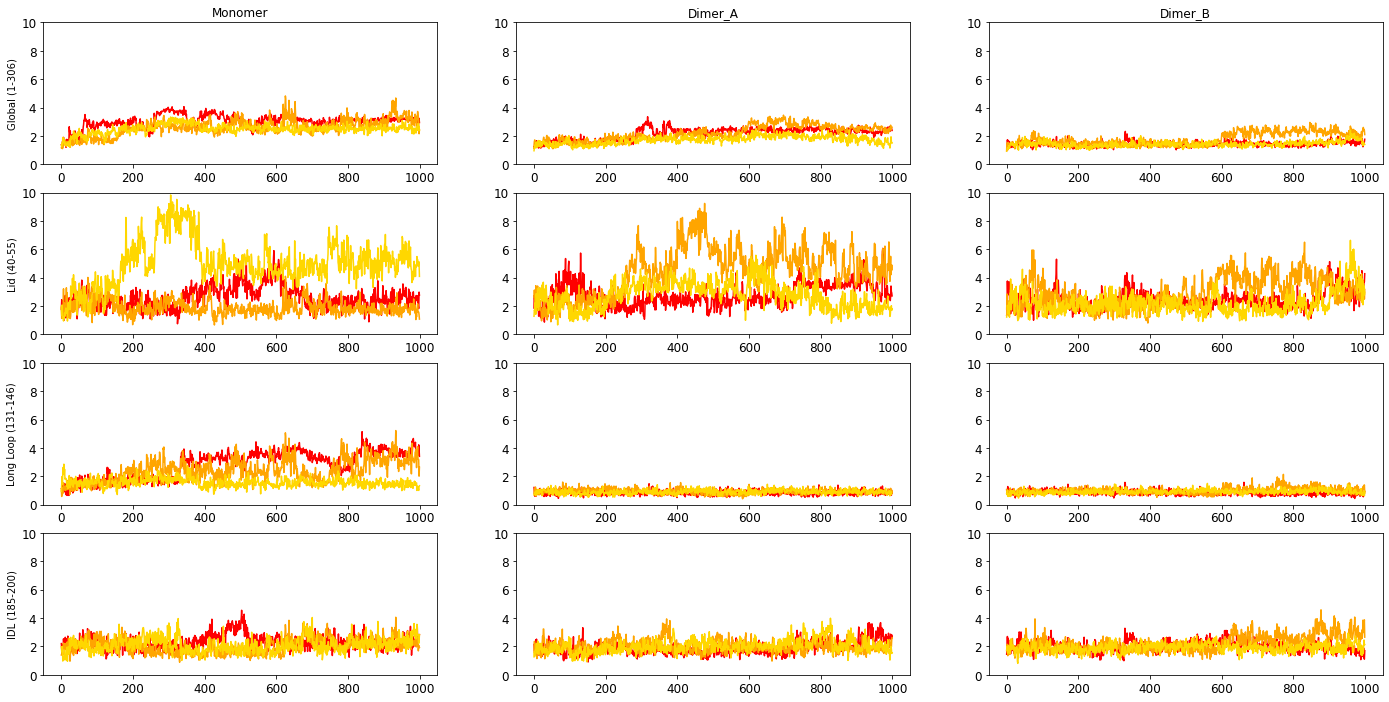

In [35]:
#    global      3:     global (1-306) 
#    lid         9:     Lid (40-55)
#    longloop  8:     Long Strand (437-452)
#    idl         7:     IDL (185-200)

fig, ax = plt.subplots(4,3,figsize=(24,12))

#apo monomer
ax[0,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,3],color='red')
ax[0,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,3],color='orange')
ax[0,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,3],color='gold')
#ax[0,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[0,0].set_ylim(0,10)

ax[1,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,9],color='red')
ax[1,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,9],color='orange')
ax[1,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,9],color='gold')
#ax[1,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[1,0].set_ylim(0,10)

ax[2,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,8],color='red')
ax[2,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,8],color='orange')
ax[2,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,8],color='gold')
#ax[2,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[2,0].set_ylim(0,10)

ax[3,0].plot(am_1_rmsd[:,0],am_1_rmsd[:,7],color='red')
ax[3,0].plot(am_2_rmsd[:,0],am_2_rmsd[:,7],color='orange')
ax[3,0].plot(am_3_rmsd[:,0],am_3_rmsd[:,7],color='gold')
#ax[3,0].axhline(am_rmsd_mean,linestyle='--',color='black')
ax[3,0].set_ylim(0,10)

#apo dimer A
ax[0,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,3],color='red')
ax[0,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,3],color='orange')
ax[0,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,3],color='gold')
#ax[0,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[0,1].set_ylim(0,10)

ax[1,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,9],color='red')
ax[1,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,9],color='orange')
ax[1,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,9],color='gold')
#ax[1,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[1,1].set_ylim(0,10)

ax[2,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,8],color='red')
ax[2,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,8],color='orange')
ax[2,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,8],color='gold')
#ax[2,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[2,1].set_ylim(0,10)

ax[3,1].plot(ad_1_rmsd_a[:,0],ad_1_rmsd_a[:,7],color='red')
ax[3,1].plot(ad_2_rmsd_a[:,0],ad_2_rmsd_a[:,7],color='orange')
ax[3,1].plot(ad_3_rmsd_a[:,0],ad_3_rmsd_a[:,7],color='gold')
#ax[3,1].axhline(ad_rmsd_mean_a,linestyle='--',color='black')
ax[3,1].set_ylim(0,10)

#apo dimer B
ax[0,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,3],color='red')
ax[0,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,3],color='orange')
ax[0,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,3],color='gold')
#ax[0,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[0,2].set_ylim(0,10)

ax[1,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,9],color='red')
ax[1,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,9],color='orange')
ax[1,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,9],color='gold')
#ax[1,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[1,2].set_ylim(0,10)

ax[2,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,8],color='red')
ax[2,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,8],color='orange')
ax[2,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,8],color='gold')
#ax[2,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[2,2].set_ylim(0,10)

ax[3,2].plot(ad_1_rmsd_b[:,0],ad_1_rmsd_b[:,7],color='red')
ax[3,2].plot(ad_2_rmsd_b[:,0],ad_2_rmsd_b[:,7],color='orange')
ax[3,2].plot(ad_3_rmsd_b[:,0],ad_3_rmsd_b[:,7],color='gold')
#ax[3,2].axhline(ad_rmsd_mean_b,linestyle='--',color='black')
ax[3,2].set_ylim(0,10)

ax[0,0].set_title("Monomer")
ax[0,1].set_title("Dimer_A")
ax[0,2].set_title("Dimer_B")

ax[0,0].set_ylabel("Global (1-306)")
ax[1,0].set_ylabel("Lid (40-55)")
ax[2,0].set_ylabel("Long Loop (131-146)")
ax[3,0].set_ylabel("IDL (185-200)")

# RMSF

### Define RMSF functions

In [36]:
## RMSF
## calculate individual rmsf (monomer/dimer) and average rmsf
## by domain/subdomain/region/reisdues of interest
## plot rmsf

def calc_rmsf(u_traj,u_ref,chain,region):
    
    selection_a = {'protomer':'backbone and (resid 1-306) and name CA',
    'domain1':'backbone and (resid 8-101) and name CA',
    'domain2':'backbone and (resid 102-184) and name CA',
    'domain3':'backbone and (resid 201-303) and name CA',
    'idl':'backbone and (resid 185-200) and name CA',
    'longloop':'backbone and (resid 131-146) and name CA',
    'lid':'backbone and (resid 40-55) and name CA',
    'nterm':'backbone and (resid 1-14) and name CA',
    'cterm':'backbone and (resid 298-306) and name CA'}
    
    selection_b = {'protomer':'backbone and (resid 307-612) and name CA',
    'domain1':'backbone and (resid 314-407) and name CA',
    'domain2':'backbone and (resid 408-490) and name CA',
    'domain3':'backbone and (resid 507-609) and name CA',
    'idl':'backbone and (resid 491-506) and name CA',
    'longloop':'backbone and (resid 437-452) and name CA',
    'lid':'backbone and (resid 346-361) and name CA',
    'nterm':'backbone and (resid 307-320) and name CA',
    'cterm':'backbone and (resid 604-612) and name CA'}
        
    if chain == 'a':
        selection = selection_a[region]
    elif chain == 'b':
        selection = selection_b[region]
    else:
        selection = region
    

    #generate average structure to use as reference
    average = align.AverageStructure(u_traj,u_ref, select='backbone and name CA',ref_frame=0).run()
    ref = average.results.universe

    #align trajectory to reference
    aligner = align.AlignTraj(u_traj,u_ref,select='backbone and name CA',in_memory=True).run()
    
    #calculate RMSF
    c_alphas = u_traj.select_atoms(selection)
    R = rms.RMSF(c_alphas).run()
    
    return(c_alphas.resids,R.results.rmsf)
    #print(selection)

### Calculate and plot  global RMSF for apo monomer and dimer

In [37]:
#monomer rmsf
am_rmsf_1 = calc_rmsf(am_1,am_0,'a','protomer')
am_rmsf_2 = calc_rmsf(am_2,am_0,'a','protomer')
am_rmsf_3 = calc_rmsf(am_3,am_0,'a','protomer')

#dimer rmsf (protomer A)
ad_rmsf_1_a = calc_rmsf(ad_1,ad_0,'a','protomer')
ad_rmsf_2_a = calc_rmsf(ad_2,ad_0,'a','protomer')
ad_rmsf_3_a = calc_rmsf(ad_3,ad_0,'a','protomer')

#dimer rmsf (protomer B)
ad_rmsf_1_b = calc_rmsf(ad_1,ad_0,'b','protomer')
ad_rmsf_2_b = calc_rmsf(ad_2,ad_0,'b','protomer')
ad_rmsf_3_b = calc_rmsf(ad_3,ad_0,'b','protomer')

(0.0, 10.0)

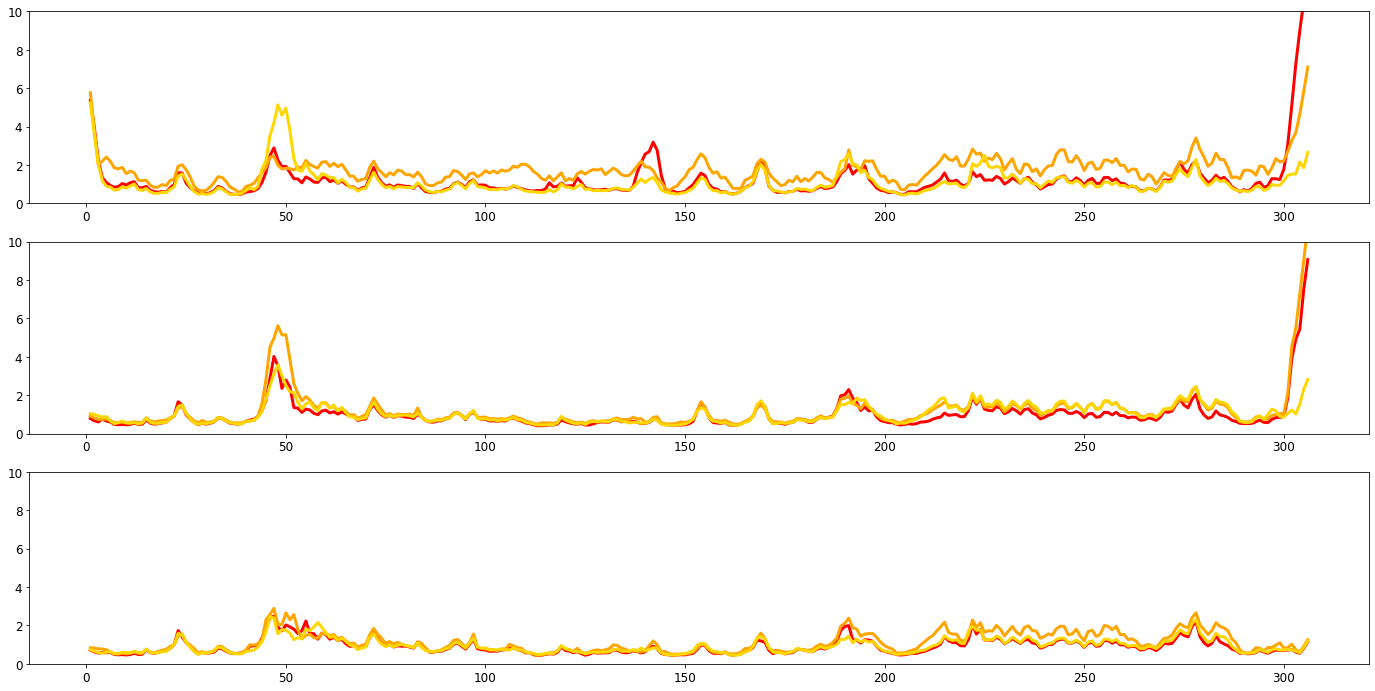

In [38]:
#plot_rmsf in a separate cell
fig, ax = plt.subplots(3,1,figsize=(24,12))

#first column: apo monomer
ax[0].plot(am_rmsf_1[0],am_rmsf_1[1],color='red',linewidth=3.0)
ax[0].plot(am_rmsf_2[0],am_rmsf_2[1],color='orange',linewidth=3.0)
ax[0].plot(am_rmsf_3[0],am_rmsf_3[1],color='gold',linewidth=3.0)
ax[0].set_ylim(0,10)

#second column: apo dimer protomer a
ax[1].plot(ad_rmsf_1_a[0],ad_rmsf_1_a[1],color='red',linewidth=3.0)
ax[1].plot(ad_rmsf_2_a[0],ad_rmsf_2_a[1],color='orange',linewidth=3.0)
ax[1].plot(ad_rmsf_3_a[0],ad_rmsf_3_a[1],color='gold',linewidth=3.0)
ax[1].set_ylim(0,10)

#third column: apo dimer protomer b
ax[2].plot(ad_rmsf_1_a[0],ad_rmsf_1_b[1],color='red',linewidth=3.0)
ax[2].plot(ad_rmsf_2_a[0],ad_rmsf_2_b[1],color='orange',linewidth=3.0)
ax[2].plot(ad_rmsf_3_a[0],ad_rmsf_3_b[1],color='gold',linewidth=3.0)
ax[2].set_ylim(0,10)

#ax[0].set_title("Monomer")
#ax[1].set_title("Dimer_A")
#ax[2].set_title("Dimer_B")

### Calculate and plot active site RMSF for apo monomer and dimer (Domain I)

In [ ]:
active_site_a = 'backbone and (resid 131-146) and name CA'
active_site_b = 'backbone and (resid 437-452) and name CA'

In [ ]:
#monomer rmsf
am_rmsf_1 = calc_rmsf(am_1,am_0,'c',active_site_a)
am_rmsf_2 = calc_rmsf(am_2,am_0,'c',active_site_a)
am_rmsf_3 = calc_rmsf(am_3,am_0,'c',active_site_a)

#dimer rmsf (protomer A)
ad_rmsf_1_a = calc_rmsf(ad_1,ad_0,'c',active_site_a)
ad_rmsf_2_a = calc_rmsf(ad_2,ad_0,'c',active_site_a)
ad_rmsf_3_a = calc_rmsf(ad_3,ad_0,'c',active_site_a)

#dimer rmsf (protomer B)
ad_rmsf_1_b = calc_rmsf(ad_1,ad_0,'c',active_site_b)
ad_rmsf_2_b = calc_rmsf(ad_2,ad_0,'c',active_site_b)
ad_rmsf_3_b = calc_rmsf(ad_3,ad_0,'c',active_site_b)

In [ ]:
#plot_rmsf in a separate cell
fig, ax = plt.subplots(3,1,figsize=(24,12))

#first column: apo monomer
ax[0].bar(am_rmsf_1[0],am_rmsf_1[1],color='red')
ax[0].bar(am_rmsf_2[0],am_rmsf_2[1],color='orange')
ax[0].bar(am_rmsf_3[0],am_rmsf_3[1],color='gold')
ax[0].set_ylim(0,10)

#second column: apo dimer protomer a
ax[1].bar(ad_rmsf_1_a[0],ad_rmsf_1_a[1],color='red')
ax[1].bar(ad_rmsf_2_a[0],ad_rmsf_2_a[1],color='orange')
ax[1].bar(ad_rmsf_3_a[0],ad_rmsf_3_a[1],color='gold')
ax[1].set_ylim(0,10)

#third column: apo dimer protomer b
ax[2].bar(ad_rmsf_1_a[0],ad_rmsf_1_b[1],color='red')
ax[2].bar(ad_rmsf_2_a[0],ad_rmsf_2_b[1],color='orange')
ax[2].bar(ad_rmsf_3_a[0],ad_rmsf_3_b[1],color='gold')
ax[2].set_ylim(0,10)

ax[0].set_title("Domain I")
ax[1].set_title("Dimer_A")
ax[2].set_title("Dimer_B")

In [18]:
## Correlated motions analysis
def get_cm_data(path):
    cm_data = glob.glob(path+'/*correl.dat')
    cm_np = np.loadtxt(cm_data[0])
    return cm_np

def plot_correl_mat(data,title):
    params = {
         'font.sans-serif': 'Arial',
         'legend.fontsize': '20',
         'axes.labelsize': '36',
         'axes.titlesize': '36',
         'xtick.labelsize': '20',
         'ytick.labelsize': '20'
    }
    pylab.rcParams.update(params)
    fig = plt.figure(figsize=(10,8))


    sns.heatmap(data,cmap='bwr_r')
    #plt.title(title)
    #plt.xlabel("Residues")
    #plt.ylabel("Residues")
    plt.savefig("{}_pr5_corrmat.png".format(title),bbox_inches='tight',dpi=300)

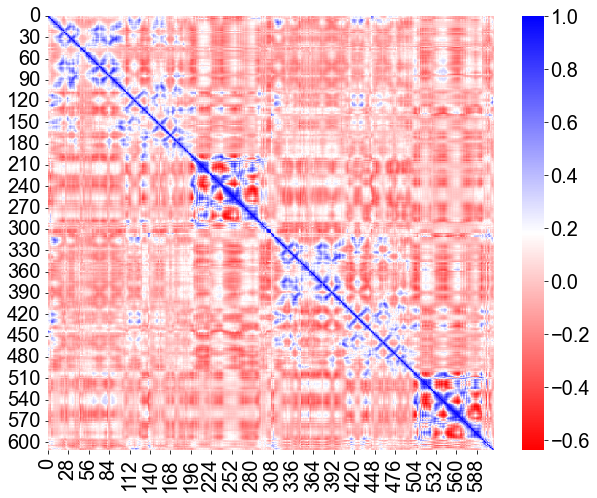

In [20]:
am_cm_dat = get_cm_data(apo_monomer_path)
ad_cm_dat = get_cm_data(apo_dimer_path)

plot_correl_mat(ad_cm_dat,'Correlated motions')

In [ ]:
## Distance based analysis
def calc_distance(u):
    dist=[]
    h41=u.select_atoms("resid 41 and name NE2")
    c145=u.select_atoms("resid 145 and name SG")
    for ts in u.trajectory:
        dist_arr = distances.distance_array(h41.positions,c145.positions,box=u.dimensions)
        dist.append((np.min(dist_arr)))
    print("Finished")
    return(dist)

am_dist_1 = calc_distance(am_1)
x_axis = list(range(0,len(am_dist_1)))
plt.plot(x_axis,am_dist_1)

In [ ]:
## Helix Analysis
def calc_helix(u,title):
    data = hel.helanal_trajectory(u, select='resid 43-53 and name CA',
                               matrix_filename='bending_matrix.dat',
                               summary_filename='summary.txt',
                               screw_filename='screw.xvg',
                               tilt_filename='local_tilt.xvg',
                               fitted_tilt_filename='fitted_tilt.xvg',
                               bend_filename='bend.xvg',
                               twist_filename='unit_twist.xvg',
                               prefix='helanal_{}_'.format(title),
                               ref_axis=[0,0,1])
    return(data)

In [ ]:
## Active Site Triangle
## Hairpin - Helix - Loop

def calc_hairpin_helix_loop(u,title):
    ## residues of interest: 346 --> 331 --> 310

    
    def calc_area(a,b,c):
        s=(a+b+c)/2
        area=(s*(s-a)*(s-b)*(s-c))**0.5
        return(area)
    
    results=[]
    for ts in u.trajectory:
        
        hairpin=u.select_atoms("resid 165 to 172 and name CA").center_of_geometry()
        helix=u.select_atoms("resid 43 to 53 and name CA").center_of_geometry()
        loop=u.select_atoms("resid 185 to 193 and name CA").center_of_geometry()
        
        hairpin_helix=np.min(distances.distance_array(hairpin,helix))
        helix_loop=np.min(distances.distance_array(helix,loop))
        loop_hairpin=np.min(distances.distance_array(loop,hairpin))
        
        area=calc_area(hairpin_helix,helix_loop,loop_hairpin)
        results.append((hairpin_helix,helix_loop,loop_hairpin,area))

    results=np.array(results).reshape(len(results),4)
    with open('{}_hairpin_helix_loop_area.npy'.format(title),'wb') as f:
        np.save(f,results)
    print("Finished") 
    return(results)

In [ ]:
## Active Site Volume

def calc_pocket_volume(u,title):
    results=[]
    for ts in u.trajectory:
        pocket=u.select_atoms("resid 24 to 27 43 to 53 140 to 145 165 to 172 185 to 193 and name CA").positions
        volume=ConvexHull(pocket).volume
        results.append(volume)
        
    results=np.array(results).reshape(len(results),1)
    with open('{}_pocket_volume.npy'.format(title),'wb') as f:
        np.save(f,results)
    print("Finished") 
    return(results)

def calc_pocket_sa(u,title):
    results=[]
    for ts in u.trajectory:
        pocket=u.select_atoms("resid 24 to 27 43 to 53 140 to 145 165 to 172 185 to 193 and name CA").positions
        volume=ConvexHull(pocket).area
        results.append(volume)
        
    results=np.array(results).reshape(len(results),1)
    with open('{}_pocket_surface_area.npy'.format(title),'wb') as f:
        np.save(f,results)
    print("Finished") 
    return(results)

In [ ]:
## Active Site Distance (C145 - H41)

def calc_h41_c145(u):
    dist=[]
    h41=u.select_atoms("resid 41 and name NE2")
    c145=u.select_atoms("resid 145 and name SG")
    for ts in u.trajectory:
        dist_arr = distances.distance_array(h41.positions,c145.positions,box=u.dimensions)
        dist.append((np.min(dist_arr)))
    print("Finished")
    return(dist)

def calc_L167_V171(u):
    dist=[]
    h41=u.select_atoms("resid 41 and name NE2")
    c145=u.select_atoms("resid 145 and name SG")
    for ts in u.trajectory:
        dist_arr = distances.distance_array(h41.positions,c145.positions,box=u.dimensions)
        dist.append((np.min(dist_arr)))
    print("Finished")
    return(dist)

def calc_h41_met49(u):
    dist=[]
    h41=u.select_atoms("resid 41 and name NE2")
    m49=u.select_atoms("resid 49 and name CE")
    for ts in u.trajectory:
        dist_arr = distances.distance_array(h41.positions,m49.positions,box=u.dimensions)
        dist.append((np.min(dist_arr)))
    print("Finished")
    return(dist)

def calc_c145_met49(u):
    dist=[]
    c145=u.select_atoms("resid 145 and name SG")
    m49=u.select_atoms("resid 49 and name CE")
    for ts in u.trajectory:
        dist_arr = distances.distance_array(c145.positions,m49.positions,box=u.dimensions)
        dist.append((np.min(dist_arr)))
    print("Finished")
    return(dist)

In [ ]:
## 173 and 185 and 167 (Triangle area)
## Calculate Active site sub-pocket contacts

def calc_s2_contacts(u,title):
    ## residues of interest: 346 --> 331 --> 310
    
    def calc_area(a,b,c):
        s=(a+b+c)/2
        area=(s*(s-a)*(s-b)*(s-c))**0.5
        return(area)
    
    results=[]
    for ts in u.trajectory:
        x173=u.select_atoms("resid 173").center_of_geometry()
        f185=u.select_atoms("resid 185").center_of_geometry()
        l167=u.select_atoms("resid 167").center_of_geometry()
        x173_f185=np.min(distances.distance_array(x173,f185))
        f185_l167=np.min(distances.distance_array(f185,l167))
        l167_x173=np.min(distances.distance_array(l167,x173))
        area=calc_area(x173_f185,f185_l167,l167_x173)
        results.append((x173_f185,f185_l167,l167_x173,area))

    results=np.array(results).reshape(len(results),4)
    with open('{}_s2_pocket.npy'.format(title),'wb') as f:
        np.save(f,results)
    print("Finished") 
    return(results)

In [ ]:
## Calculate angle within trajectory

def calc_angle(u_traj):
    
    def unit_vector(vector):
        return(vector/np.linalg.norm(vector))
    def angle_between(v1,v2):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return(math.degrees(np.arccos(np.clip(np.dot(v1_u,v2_u),-1.0,1.0))))
    
    vec1=[]
    vec2=[]
    vec3=[]
    for ts in u_traj.trajectory:
        cys=u_traj.select_atoms("resid 145 and name SG").positions()
        his=u_traj.select_atoms("resid 41 and name NE2").positions()
        met=u_traj.select_atoms("resid 49 and name SD").positions()
        vec1.append(cys-his)
        vec2.append(his-met)
        vec3.append(met-cys)
        
    angles=[]
    for i,j in zip(vec1,vec2):
        angles.append(angle_between(vec1,vec2))
        
    return(angles)

In [ ]:
## Clustering (10%)

#Calculate pocket

def calc_pocket(u):
    coors=[]
    pocket=u.select_atoms("protein and resid 24-28 39-50 116-119 141-147 167 171-175 186-192 and name CA")
    natoms=len(pocket)
    for ts in u.trajectory:
        coors.append(pocket.positions)
    #coors=np.array(coors).reshape(natoms)
    return(coors)

def calc_pocket_rmsd(u_traj,u_ref):
    R = mda.analysis.rms.RMSD(u_traj,u_ref,
                             select="protein and resid 1-167 169-300 and name CA",
                             groupselections=["protein and resid 24-28 39-50 116-119 141-147 167 171-175 186-192 and name CA"])
    R.run(start=0,stop=330000,step=100)
    return(R.rmsd.T)

# Kmeans clustering 

def cluster_kmeans(data,title):
    data=np.array(data).reshape(-1,1)
    sse = []
    silhouette_coefficients = []
    kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}
    for k in range(1, 100):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        if k > 1:
            score = silhouette_score(data, kmeans.labels_)
            silhouette_coefficients.append(score)
    plot_sse(sse,title)
    plot_silhouette(silhouette_coefficients,title)
    kl = KneeLocator(range(1, 100), sse, curve="convex", direction="decreasing")
    nclusters_elbow=kl.elbow
    nclusters_silhouette=silhouette_coefficients.index(max(silhouette_coefficients))+2
    kmeans_clusters_elbow = KMeans(init="random",n_clusters=nclusters_elbow,n_init=10,max_iter=300,random_state=42)
    kmeans_clusters_elbow.fit(data)
    kmeans_clusters_silhouette = KMeans(init="random",n_clusters=nclusters_silhouette,n_init=10,max_iter=300,random_state=42)
    kmeans_clusters_silhouette.fit(data)
    print("Number of clusters from elbow = {}".format(nclusters_elbow))
    print("Number of clusters from max silhouette coefficient = {}".format(nclusters_silhouette))
    print("Returning as pair: kmeans collected from {} clusters, kmeans collected from {} clusters)".format(nclusters_elbow,nclusters_silhouette))
    return(kmeans_clusters_elbow,kmeans_clusters_silhouette)

In [ ]:
## HBonds

def calc_l167_g170_hbond(u,title):
    
    def unit_vector(vector):
        return(vector/np.linalg.norm(vector))
    def angle_between(v1,v2):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return(math.degrees(np.arccos(np.clip(np.dot(v1_u,v2_u),-1.0,1.0))))
    
    dist=[]
    angle=[]
    hbond=[]
    l167o=u.select_atoms("resid 167 and name O")
    g170n=u.select_atoms("resid 170 and name N")
    g170h=u.select_atoms("resid 170 and name HN")
    for ts in u.trajectory:
        l167o_coor=u.select_atoms("resid 167 and name O").center_of_geometry()
        g170n_coor=u.select_atoms("resid 170 and name N").center_of_geometry()
        g170h_coor=u.select_atoms("resid 170 and name HN").center_of_geometry()
        dist1=np.min(distances.distance_array(l167o_coor,g170n_coor))
        dist.append((dist1))
        vec1=l167o_coor-g170h_coor
        vec2=g170n_coor-g170h_coor
        angle1=angle_between(vec1,vec2)
        angle.append(angle1)
        if dist1 < 4 and 120 < angle1 < 200:
            hbond.append(1)
        else:
            hbond.append(0)
    
    results=[]
    for i,j,k in zip(dist,angle,hbond):
        results.append((i,j,k))
    
    results=np.array(results).reshape(len(dist),3)
    
    with open('{}_l167_g170_hbond.npy'.format(title),'wb') as f:
        np.save(f,results)   
        
    print("Finished")
    
    return(results)

In [ ]:
## M49 Penetration into S2

def calc_m49_s2(u,title):
    dist=[]
    m49=u.select_atoms("resid 49")
    s2=u.select_atoms("resid 165-167 188-192 and name CA")
    for ts in u.trajectory:
        dist_arr = distances.distance_array(m49.center_of_geometry(),s2.center_of_geometry())
        dist.append((np.min(dist_arr)))
    print("Finished")
    
    results=np.array(dist).reshape(len(dist),1)
    
    with open('{}_m49_s2_contacts.npy'.format(title),'wb') as f:
        np.save(f,results)
    
    
    return(results)

In [ ]:
## PCA

def calc_pca(u):
    PSF_pca=pca.PCA(u, select='protein and resid 24-28 39-50 116-119 141-147 167 171-175 186-192 and name CA')
    PSF_pca.run()
    n_pcs = np.where(PSF_pca.cumulated_variance > 0.95)[0][0]
    atomgroup = u_wt_chaina.select_atoms("protein and resid 24-28 39-50 116-119 141-147 167 171-175 186-192 and name CA")
    pca_space = PSF_pca.transform(atomgroup, n_components=n_pcs)
    return(pca_space)

In [ ]:
## from data generated outside of trajectory

## Correlation Matrix (from correlmat data)
## PKA (from propka.dat files)
## POVME R10 and R16 (from povme data)

In [ ]:
## Miscellaneous Scripts
### RCSB_Process
### del_dock scrores and del_merge
### script_tester